# Why has housing become so expensive?
_an analytics journey led by Adrian Lechter_

### A Brief Prologue ( _"Why am I doing this?"_ )
With an important election year in front of us and with the political discourse more divisive than ever, the need to find some reliable sources of truth to have respectful yet spirited debate has become more important than ever. Folks from both sides of the aisle appear to be digging deeper into their echo chambers, which is only making our political discourse less and less truth-seeking.


I hope to put a dent in that approach beginning with this article.

While I've been extremely fortunate to learn Data Science and Analytics from my times working at Uber and Wag, I feel a pressing need to leverage these skills to benefit a wider audience. Data has the ability to improve everyone's decision-making, whether that be the CEO of a Softbank-funded startup, the teacher that lives next door to you or your grandparent that doesn't know how to open an internet browser.



Whether you are a post office worker, or a Private Equity Vice President, I hope that anyone who reads my research becomes better informed about these issues I'll be studying that matter to us all greatly. Any and all feedback is highly encouraged and welcomed.


------------------------------------

### Framing our Discussion

For my first deep dive, I wanted to focus on the topic of housing, and why it's become so expensive. Anyone who wants to live in the United States full-time as an adult has to think about the costs of housing, and many folks specifically within my age-group are struggling with the challenge of finding good-quality, affordable homes. My hope in the ensuing analysis is to explore various causes for this phenomenon and explore some actions that can be taken from the data utilized here. Feel free to skip the following **Importing Data** section if you want to dive straight into my findings.

### Importing Data

I've included detailed bulleted notes below on all of my data sources:
- `AHETPI.csv` = [Average Hourly Earnings of Production and Nonsupervisory Employees, Total Private (FRED)](https://fred.stlouisfed.org/series/AHETPI)
- `GDP.csv` = [United States Historical GDP (FRED)](https://fred.stlouisfed.org/series/GDP/)
- `ASPUS.csv` = [Average Sales Price of Houses Sold in the United States (FRED)](https://fred.stlouisfed.org/series/ASPUS)
- `MAFAINUSA646N.csv` = [Mean Family Income in the United States (FRED)](https://fred.stlouisfed.org/series/MAFAINUSA646N)
- `MEHOINUSA646N.csv` = [Median Family Income in the United States (FRED)](https://fred.stlouisfed.org/series/MEHOINUSA646N)
- `MSPUS (1).csv` = [Median Sale Price of Houses Sold in the United States (FRED)](https://fred.stlouisfed.org/series/MSPUS)
- `RHORUSQ156N.csv` = [Homeownership Rate for the United States (FRED)](https://fred.stlouisfed.org/series/RHORUSQ156N)
- `df_tnx` = time series graph of the 10 year treasury index (ticker: _^TNX_ ), imported from "ffn" python package that pulls data from Yahoo Finance

In [1]:
#Import Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta, datetime
import time
from IPython.display import display, HTML, display_html, Markdown
import warnings
import monthdelta as md
from labellines import labelLine, labelLines #See https://bit.ly/2RyXstF for documentation
import ffn as f
import joypy
import matplotlib.style as style
import matplotlib
from collections import OrderedDict
import matplotlib.colors as mcolors
from matplotlib import cm

#Display visuals in the notebook and turn off warning flags
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
#Import data
df_average_hourly_earnings_of_production_and_nonsupervisory_employees = pd.read_csv('AHETPI.csv')
df_GDP = pd.read_csv('GDP.csv')
df_average_house_price = pd.read_csv('ASPUS.csv')
df_median_house_price = pd.read_csv('MSPUS (1).csv')
df_average_household_income = pd.read_csv('MAFAINUSA646N.csv')
df_median_household_income = pd.read_csv('MEHOINUSA646N.csv')
df_homeownership_rate = pd.read_csv('RHORUSQ156N.csv')


#Housing dataset: comparing housing prices across cities
df_housing_master = pd.read_csv('df_housing_master.csv')

#Import 10 year treasury data
df_tnx = f.get('^TNX', start='1990-01-01')


In [3]:
#Removing unecessary column
df_housing_master = df_housing_master.drop('Unnamed: 0', 1)

#Converting string column to datetime
df_housing_master['Date'] = pd.to_datetime(df_housing_master['Date']) 

df_housing_1995 = df_housing_master[(df_housing_master['Date'] >= dt.date(1995,1,1))]

#Rename column in average hourly wages dataframe
df_average_hourly_earnings_of_production_and_nonsupervisory_employees. \
rename(columns={'AHETPI':'Average Hourly Earnings'}, inplace=True)

#Convert date column in GDP dataframe to datetime
df_GDP['DATE'] = pd.to_datetime(df_GDP['DATE'])

#Cleaning up date column on hourly earnings
df_average_hourly_earnings_of_production_and_nonsupervisory_employees['DATE'] = \
pd.to_datetime(df_average_hourly_earnings_of_production_and_nonsupervisory_employees['DATE'])


#Combining these 2 dataframes
df_combine = pd.merge(df_average_hourly_earnings_of_production_and_nonsupervisory_employees,df_GDP, 
                      on = 'DATE', how = 'left')

#Filling in missing values in GDP (spot-checked to confirmt this is linear)
df_combine['GDP'] = round(df_combine['GDP'].interpolate(),3)

#Adding % change columns for GDP and Average Hourly Earnings
df_combine['GDP Percent Change'] = round(df_combine['GDP'].pct_change(),3)
df_combine['Average Hourly Earnings Percent Change'] \
                                                    = round(df_combine['Average Hourly Earnings'].pct_change(),3)

#Calculate rolling 1yr GDP and Earnings Percent Changes
GDP_total = 0
earnings_total = 0

for i in range(1,7):
    GDP_total += df_combine['GDP Percent Change'].shift(i)
    earnings_total += df_combine['Average Hourly Earnings Percent Change'].shift(i)

df_combine['GDP Percent Change Rolling Mean'] = GDP_total / 6
df_combine['Average Hourly Earnings Rolling Mean'] = earnings_total / 6

#Rename column in average household income
df_average_house_price.rename(columns={'ASPUS':'Average House Price'}, inplace=True)

#Rename column in median household income
df_median_house_price.rename(columns={'MSPUS':'Median House Price'}, inplace=True)

#Rename column in average household income
df_average_household_income.rename(columns={'MAFAINUSA646N':'Average Household Income'}, 
                                   inplace=True)

#Rename column in median household income
df_median_household_income.rename(columns={'MEHOINUSA646N':'Median Household Income'}, 
                                   inplace=True)

#Convert date to datetime in median income dataset
df_median_household_income['DATE'] = \
                        pd.to_datetime(df_median_household_income['DATE'])

#Convert date to datetime in average house price dataset
df_average_house_price['DATE'] = \
                        pd.to_datetime(df_average_house_price['DATE'])


#Convert date to datetime in average income dataset
df_average_household_income['DATE'] = \
                        pd.to_datetime(df_average_household_income['DATE'])

#Convert date to datetime in median income dataset
df_median_house_price['DATE'] = \
                        pd.to_datetime(df_median_house_price['DATE'])

#Give all columns names, rename columns, ensure date values are dates
df_tnx = df_tnx.reset_index()
df_tnx.rename(columns={'Date':'DATE'}, inplace=True)

#Combining average and median incomes
df_average_and_median_household_income = pd.merge(df_average_household_income,df_median_household_income,
                                                 how = 'left')

#Adding new column that is the difference between the Average and median households
df_average_and_median_household_income['Average - Median'] = \
                        df_average_and_median_household_income['Average Household Income'] - \
                        df_average_and_median_household_income['Median Household Income']

#Add % change columns for median household income and `Average - Median`
df_average_and_median_household_income['Pct Change Median'] = \
            df_average_and_median_household_income['Median Household Income'].pct_change()

df_average_and_median_household_income['Pct Change Avg - Med'] = \
            df_average_and_median_household_income['Average - Median'].pct_change()

#Calculate average pct change in last 10 years
median_household_avg_pct_change_L10Y = \
                                df_average_and_median_household_income['Pct Change Median'][56:66].mean()
average_minus_median_avg_pct_change_L10Y = \
                                df_average_and_median_household_income['Pct Change Avg - Med'][56:66].mean()

#Calculate values for new row

new_median = \
            df_average_and_median_household_income['Median Household Income'].loc[65] \
            * (1 + median_household_avg_pct_change_L10Y)

new_avg_minus_median = \
            df_average_and_median_household_income['Average - Median'].loc[65] \
            * (1 + average_minus_median_avg_pct_change_L10Y)

new_avg = new_median + new_avg_minus_median

#Drop unecessary rows
df_average_and_median_household_income = \
                df_average_and_median_household_income.drop(['Pct Change Median',
                                                             'Pct Change Avg - Med'], axis = 1)

#Manually add next row with predictions
df_average_and_median_household_income.loc[66] = ['2019-01-01', new_avg,
                                                  new_median, new_avg_minus_median] 

#Convert date to datetime for average and median household income
df_average_and_median_household_income['DATE'] = \
                        pd.to_datetime(df_average_and_median_household_income['DATE'])

#Round columns
df_average_and_median_household_income = round(df_average_and_median_household_income,2)

#Only pull out median income with projections (for GDP comparison)
df_median_household_income_projected = \
                        pd.DataFrame(df_average_and_median_household_income[['DATE',
                                                                             'Median Household Income']] )

#Combining median income and GDP dataframes
df_combine2 = pd.merge(df_GDP,df_median_household_income_projected,
                      on = 'DATE')

#Convert date to datetime in df_combine2 dataset
df_combine2['DATE'] = pd.to_datetime(df_combine2['DATE'])


#Adding % change columns for GDP and median income
df_combine2['GDP Percent Change'] = round(df_combine2['GDP'].pct_change(),3)
df_combine2['Median Household Income Percent Change'] \
                                                    = round(df_combine2['Median Household Income'].pct_change(),3)

#Calculate rolling 5yr GDP and Median income Percent Change
GDP_total = 0
median_income_total = 0

for i in range(1,3):
    GDP_total += df_combine2['GDP Percent Change'].shift(i)
    median_income_total += df_combine2['Median Household Income Percent Change'].shift(i)

df_combine2['GDP Percent Change Rolling Mean'] = GDP_total / 2
df_combine2['Median Household Income Rolling Mean'] = median_income_total / 2


#Start df_combine2 after 1984 (no median income data prior to this)
df_combine2 = df_combine2[(df_combine2['DATE'] > dt.date(1986,1,1))]

#Combine 2019 estimates of household income, with average household price; do the same for median house prices
df_average_and_median_salary_and_average_housing = \
                        pd.merge(df_average_and_median_household_income,df_average_house_price)
df_average_and_median_salary_and_median_housing = \
                        pd.merge(df_average_and_median_household_income,df_median_house_price)

#Convert date to datetime
df_average_and_median_salary_and_average_housing['DATE'] = \
                        pd.to_datetime(df_average_and_median_salary_and_average_housing['DATE'])
df_average_and_median_salary_and_median_housing['DATE'] = \
                        pd.to_datetime(df_average_and_median_salary_and_median_housing['DATE'])

#Specify new dataframe for graphing
df_average_salary_and_housing = \
                        df_average_and_median_salary_and_average_housing[['DATE','Average Household Income',
                                                             'Average House Price']]
df_median_salary_and_housing = \
                        df_average_and_median_salary_and_median_housing[['DATE','Median Household Income',
                                                             'Median House Price']]


#Add Housing as % of income column
df_average_salary_and_housing['Housing-Income Ratio'] = \
        df_average_salary_and_housing['Average House Price'] \
        / df_average_salary_and_housing['Average Household Income']

#Add Housing as % of income column
df_median_salary_and_housing['Housing-Income Ratio'] = \
        df_median_salary_and_housing['Median House Price'] \
        / df_median_salary_and_housing['Median Household Income']

#Relabel colummn for homeownership rate dataframe
df_homeownership_rate.columns = (['Date', 'Homeownership Rate'])

# Convert date to datetime format and only look at data starting around financial crisis
df_homeownership_rate['Date'] = pd.to_datetime(df_homeownership_rate['Date'])
df_homeownership_rate_graph = df_homeownership_rate[(df_homeownership_rate['Date'] >= dt.date(2004,1,1))]

#Convert date column in treasury dataset to datetime
df_tnx['DATE'] = df_tnx.DATE.map(lambda x: x.strftime('%Y-%m-%d'))

#Create new average housing dataframe only looking from 1990 onwards, also convert date column into datetime
df_average_housing_1990 = df_average_house_price[(df_average_house_price['DATE'] >= dt.date(1990,1,1))]
df_average_housing_1990['DATE'] = df_average_housing_1990.DATE.map(lambda x: x.strftime('%Y-%m-%d'))

#Merge average housing and tras
df_tnx_with_average_housing_1990 = pd.merge(df_average_housing_1990,df_tnx, on = 'DATE')

df_tnx_with_average_housing_1990_melt = pd.melt(df_tnx_with_average_housing_1990,
                               id_vars = ['DATE'], 
                                    value_vars= ['Average House Price', 'tnx'])

df_tnx_with_average_housing_1990_melt['DATE'] = pd.to_datetime(df_tnx_with_average_housing_1990_melt['DATE'], errors='coerce')

#Making final modifications to this dataframe so it can be graphed
df_graphing_tnx = \
        df_tnx_with_average_housing_1990_melt[df_tnx_with_average_housing_1990_melt['variable'] == 'tnx']
df_graphing_tnx = df_graphing_tnx.rename(columns = {'value': '10 Year Treasury Rate'})
df_graphing_average_housing = \
 df_tnx_with_average_housing_1990_melt[df_tnx_with_average_housing_1990_melt['variable'] == 'Average House Price']
df_graphing_average_housing = df_graphing_average_housing.rename(columns = {'value': 'Average House Price'})

### Housing Deep Dive

It is clear that the average price of housing has increased considerably since the 1960s, as this initial graph shows:

<Figure size 648x864 with 0 Axes>

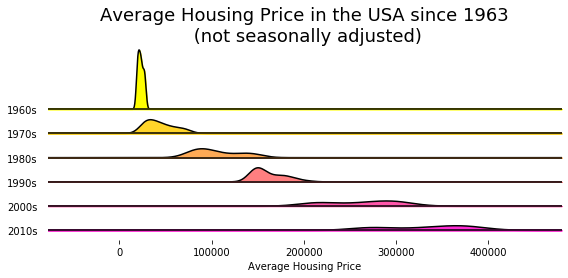

In [41]:
#Going to plot ridgeplot ('joyplot') here
df_average_house_price['Year'] = \
                pd.DatetimeIndex(df_average_house_price['DATE']).year

df_average_house_price['Decade'] = \
    df_average_house_price['Year'].apply(lambda x:'1960s' if x < 1970
                                                           else ('1970s' if x >= 1970 and x < 1980
                                                           else ('1980s' if x >= 1980 and x < 1990
                                                           else ('1990s' if x >= 1990 and x < 2000
                                                           else ('2000s' if x >= 2000 and x < 2010
                                                           else ('2010s' if x >= 2010 and x < 2020 
                                                           else ('2020s' if x >= 2020 else 'N/A')))))))

# display(df_average_house_price.head())
plt.figure(figsize = (9,12))
fig, axes = joypy.joyplot(df_average_house_price, by="Decade", colormap=cm.spring_r, figsize = (8,3.25))
                          #,title = 'Average Housing Price in the USA since 1963');
plt.title('Average Housing Price in the USA since 1963\n (not seasonally adjusted)', fontsize = 18)
# plt.suptitle('(not seasonally adjusted)', fontsize = 14)
plt.xlabel("Average Housing Price", fontsize = 10);
plt.ylabel("Year", fontsize = 10);

Owning a house used to also be considered a sure bet to unlock the American Dream; however, the increased variance in housing prices during the most recent decades attests to the fact that this asset has become significantly riskier and is not a sure-way of unlocking wealth as it had been historically.

Of course, this ridgeplot alone doesn't tell us too much. Some folks may be wondering from this graph how housing prices have increased relative to inflation and other key indicators. 

To address this, I studied how the median price of housing (what I consider to be the housing cost for the layperson) and median income (the layperson income) have changed over time. In the plot below, I graph the US median housing-income ratio (simply, the median price of housing divided by the median income) to better understand how these datapoints changed relative to each other.

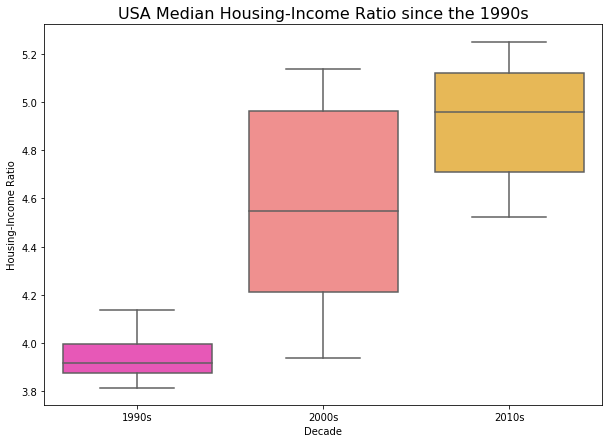

In [5]:
df_median_salary_and_housing_1990_onwards = \
                        df_median_salary_and_housing[df_median_salary_and_housing['DATE'] >= dt.date(1990,1,1)]

# df_median_salary_and_housing_1990_onwards.info()
df_median_salary_and_housing_1990_onwards['Year'] = \
        pd.DatetimeIndex(df_median_salary_and_housing_1990_onwards['DATE']).year
# df_median_salary_and_housing_1990_onwards.head(30)

df_median_salary_and_housing_1990_onwards['Decade'] = \
    df_median_salary_and_housing_1990_onwards['Year'].apply(lambda x:'1990s' if x <= 1999
                                                           else ('2000s' if x >= 2000 and x <= 2009
                                                           else ('2010s' if x >= 2010 else 'N/A')))

plt.figure(figsize = (10,7))
sns.boxplot(x = 'Decade',y = 'Housing-Income Ratio', data = df_median_salary_and_housing_1990_onwards,
           palette= 'spring')
plt.title('USA Median Housing-Income Ratio since the 1990s', fontsize = 16)
plt.show()

As the chart above demonstrates, the median price of housing has become ~20% more expensive relative to the median income (or the median income dropped 20% relative to the price of housing; most realistically this phenomenon is some combination of the two). While there is certainly more data we can look into at this point, we have at least identified that housing prices have increased in the last couple decades, and that it has increased relative to the income generated by the layperson.

What's causing this? I believe institutional homeownership plays a large role here, as large banks and other financial institutions have exercised their lien rights to acquire properties that were mortgaged through the predatory lending practices that caused the 2008 financial crisis.

As the following graph demonstrates, the US homeownership rate ( _or the % of homes owned by an individual living in the property_ ) has dropped following the 2008 crisis. I've included some relevant timelined events in the graph to provide additional key context around this trend.

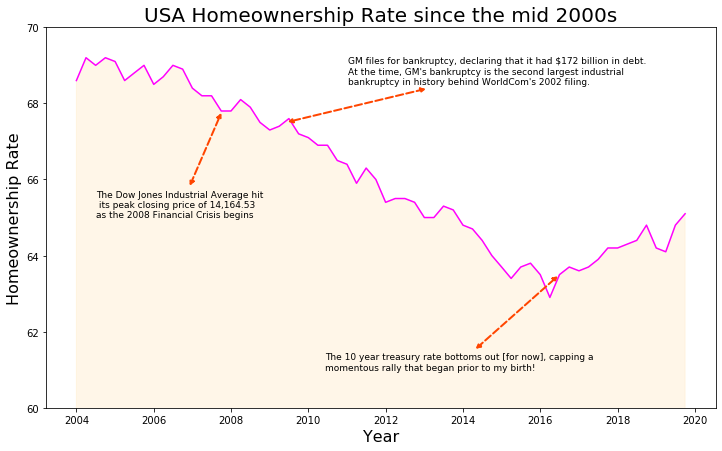

In [6]:
# Make the same graph
x = df_homeownership_rate_graph['Date']
y = df_homeownership_rate_graph['Homeownership Rate']
plt.figure(figsize = (12,7))
plt.fill_between(x, y, color="moccasin", alpha=0.3)
plt.plot(x, y, color="fuchsia")
 
# Add titles
plt.title("USA Homeownership Rate since the mid 2000s", loc="center", fontsize = 20)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Homeownership Rate", fontsize = 16)
# box_text = 'This represents a ~6% drop since the mid 2000s'
# plt.text(dt.date(2014,12,1), 68.5, box_text, size=9, rotation=0,
#          ha="center", va="center",
#          bbox=dict(boxstyle="round",
#                    ec=(1., 0.5, 0.5),
#                    fc=(1., 0.8, 0.8),
#                    )
#          )
plt.ylim(60,70)
plt.annotate(f'The Dow Jones Industrial Average hit \n its peak closing price of 14,164.53 \n' +
             'as the 2008 Financial Crisis begins', 
             xy=(dt.date(2007,10,9), 67.8),
             xycoords='data',
             xytext=(dt.date(2004,7,9), 65),
             textcoords='data', size = 9,
             arrowprops=dict(arrowstyle= '<|-|>',
                             color='orangered',
                             lw=2,
                             ls='--'))

plt.annotate(f'GM files for bankruptcy, declaring that it had $172 billion in debt. \n' +
             f'''At the time, GM's bankruptcy is the second largest industrial \n''' +
             f'''bankruptcy in history behind WorldCom's 2002 filing.''', 
             xy=(dt.date(2009,6,1), 67.5),
             xycoords='data',
             xytext=(dt.date(2011,1,9), 68.5),
             textcoords='data', size = 9,
             arrowprops=dict(arrowstyle= '<|-|>',
                             color='orangered',
                             lw=2,
                             ls='--'))

plt.annotate(f'The 10 year treasury rate bottoms out [for now], capping a \n' +
             f'''momentous rally that began prior to my birth!''', 
             xy=(dt.date(2016,7,1), 63.5),
             xycoords='data',
             xytext=(dt.date(2010,6,9), 61),
             textcoords='data', size = 9,
             arrowprops=dict(arrowstyle= '<|-|>',
                             color='orangered',
                             lw=2,
                             ls='--'))
plt.show()

While large institutions like GM and Bear Sterns in the late 2000s sought out bailouts, so did the layperson. As this graph shows, a smaller percentage of folks were able to maintain ownership of their properties as mass mortgage defaults made financiers like Blackstone the largest home owners in the country. This trend has rebounded more recently, which I believe has something to do with borrowing costs bottoming out (as noted in the graph).

On the topic of borrowing costs, I do seperately believe that decreasing interest rates have also driven up the cost of housing. When you plot treasury yields against average housing price over time, the trend sticks out very notably. 



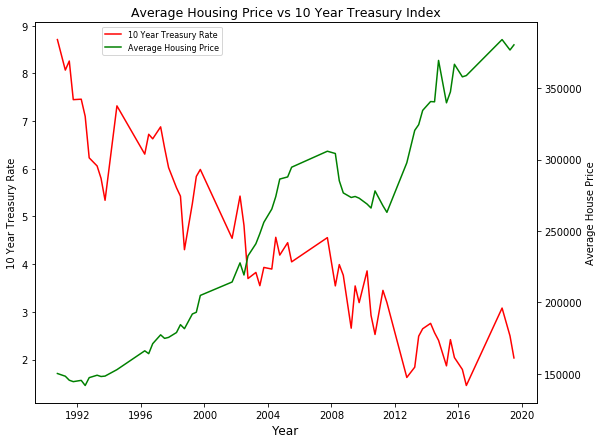

In [47]:
plt.figure(figsize = (9,7))
ax = sns.lineplot(x="DATE", y='10 Year Treasury Rate', legend = False,
             color = 'r', data=df_graphing_tnx)
plt.xlabel("Year", fontsize = 12)
ax2 = ax.twinx()
sns.lineplot(x="DATE", y='Average House Price',
             data=df_graphing_average_housing, color = 'green', legend = False, 
             ax=ax2).set_title('Average Housing Price vs 10 Year Treasury Index', fontsize = 12.5)
ax.figure.legend(['10 Year Treasury Rate', 'Average Housing Price'], loc = 10,  
                 prop={'size': 8}, bbox_to_anchor=(0.25,0.8))
plt.xlabel("Year", fontsize = 12)
plt.show()

A consistent decrease in 10 year treasury yields is accompanied by an increase in housing prices. Why? As interest rates fall, the costs of borrowing money also drops. And when money becomes cheap to borrow, this disproportionally benefits large corporations and funds that have access to massive credit revolvers. While a family can borrow money against their property or some of the assets they own, Real Estate companies and large banks have many more assets to collateralize their loans against, and lenders are happy to capitalize these groups with significant leverage.

Before moving forward, I do have to make one quick note on multicolinearity. Basically, while I have identified 2 factors that are driving increased housing prices (institutional homeownership and decreasing borrowing costs), these items are also probably correlated with each other. Lower borrowing costs probably have a direct impact on institutional home ownership (when money is cheap, large institutions borrow more and can then also own more housing). I do still believe these 2 features are very important in understanding how the capital markets operate, so I deliberately chose to leave these here.

The effects of increased housing prices are felt all over the country, more dramatically in major US cities, as we can see below.



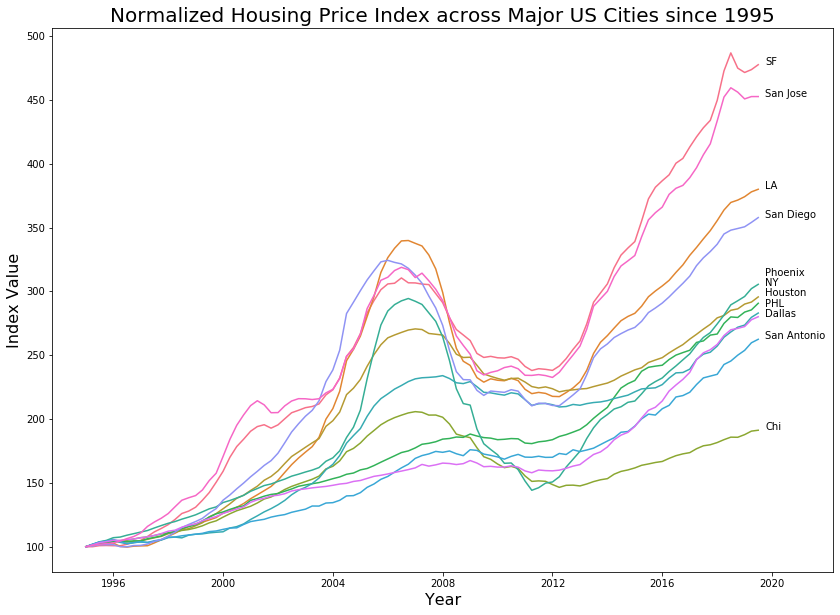

In [48]:
df_housing_1995_melt = pd.melt(df_housing_1995,
                               id_vars = ['Date'], 
                                    value_vars= ['SF','LA','NY','Chi','Houston','Phoenix','PHL',
                                                 'San Antonio', 'San Diego','Dallas',
                                               'San Jose'])
# Convert date to datetime format
df_housing_1995_melt['Date'] = pd.to_datetime(df_housing_1995_melt['Date'])

# Reshape data to find the last date with corresponding values
df_pivot = df_housing_1995_melt.pivot(values='value', index='Date', columns='variable').sort_index()

# Get the last date
last_day = df_pivot.last('D')

# Reshape data to make it easier to iterate over it
last_day = last_day.stack().sort_values()

# In this step we equally space values that are too close to each other. So or labels don't overlap.
# You can skip this step if lines are not too close too each other at the end
mask = last_day.diff() < 10
last_day[mask] = 8
last_day[mask | mask.shift(-1)] = last_day[mask | mask.shift(-1)].cumsum()


plt.figure(figsize = (14,10))
_ = sns.lineplot(x='Date', y='value', hue='variable', data=df_housing_1995_melt, legend=False)

# Iterate over series
for (date, label), value in last_day.iteritems():
    # Annotate label, DateOffset moves you labels to the right
    plt.annotate(label, (date + pd.DateOffset(90), value))
    # Move the right limit of the x axis to the right
_ = plt.xlim(right=date + pd.DateOffset(1000))

plt.title("Normalized Housing Price Index across Major US Cities since 1995", loc="center", fontsize = 20)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Index Value", fontsize = 16);

It's very clear that the costs of housing have disproportionally impacted California compared to other states, as 4 of the top 5 most expensive cities by 2020 are based in that state. And while I did pull this data directly from the Federal Reserve of St. Louis, I do have a degree of skepticism of how accurate these values are given New York's relatively low placement, especially compared to cities like San Diego or Los Angeles.

### Conclusion

While housing has certainly gotten noticeably more expensive in the last couple decades, there are at least 2 learnings from this analysis that anyone can take away.
- **The best time to get a mortgage is when interest rates are low.** There's something to be said about institutional homeownership and borrowing costs having a clear and inverse relationship. As an individual, we should look to borrow against our assets when the costs of doing so are at their lowest [which the large players are certainly already doing].
- While California certainly has plenty to offer its residents in the form of career opportunities, beautiful national parks and some of the largest cities in the country, living there clearly comes at a cost. **If you are particularly sensitive to housing prices in making a decision on where to live, you should probably avoid California.**

As a skeptic, I also embrace and want to note the holes that can be poked in my argument; I've included a couple below:
- _Labor hours as a confounding variable:_ As my housing-income boxplot showed, while the price of housing probably has increased relative to the layperson's income, there are probably additional variables that can explain that phenomenon more holistically. The available hours that folks are able to work in a given day represents one such variable. Basically, if it turns out that the gig economy has decreased the available hours that an individual can work in the day, this would probably lead to lower normalized incomes.
- _Thinking about living costs in terms of land costs vs housing costs:_ Another idea flagged to me had to do with the way I measured housing costs themselves. Given the different ways to report housing prices and how most of this data is accessible in some pre-aggregated fashion, it can be subject to certain biases, including those of the researches that make this data accessible in the first place. To offset this effect, we could potentially use a less complex data source that is generally considered more transparent: the price of the land on which the housing itself sits on.
- _Additional causes:_ I would've spent an entire year working on this article if I were to effectively capture every possible and reasonable explanation for the increase housing price pheonomenon. A decrease in supply of available land in major cities, increased reliance on city hubs as a source of high-income employment and legislation across various levels of government probably have some role to play here too, amongst a multitude of other factors.

Thank you for making it this far; I welcome all questions/comments and hope you'll explore my future research.

### Acknowledgements
- I'd like to thank Mykola Zotko for helping fix some nuanced issues with my graph labeling. Additionally, a special thank you to Zach Moskow, Benny Bursztyn, Lindsey Bails and Gladys Ndagire who offered to help me via LinkedIn. Another callout goes out to Eric Weinstein, Lex Friedman, Sam Harris, Joe Rogan the other members of the "Intellectual Dark Web" who inspired me to pursue this research. Most importantly, I'd like to make a huge call out to my wife **Myrna Perez** who gives me the support and love I need to drive my research forward.

### Appendix 
I'm leaving this one graph as a bonus just because I think it looks cool. In a previous iteration of this research, I modeled how GDP growth and average hourly earnings growth have changed over time.

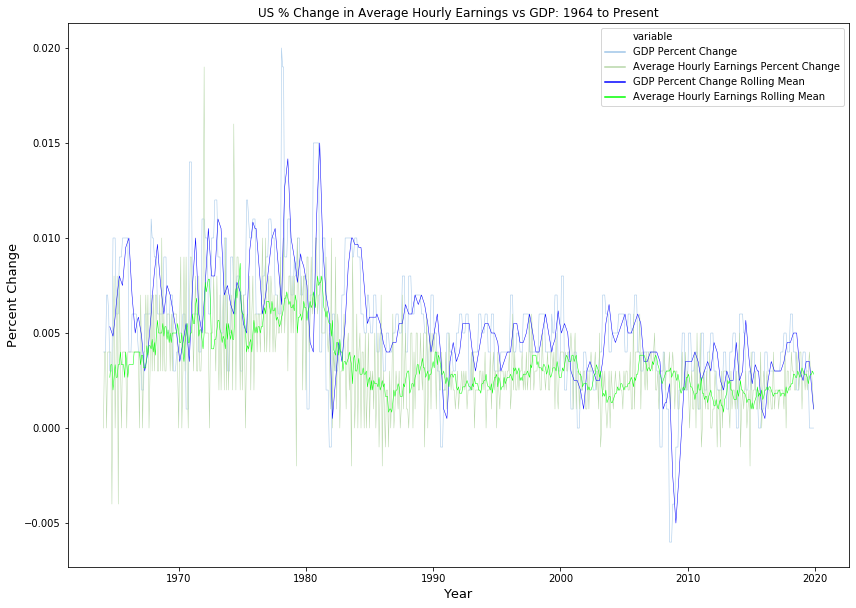

In [50]:
#Only interested in data from 1990 onwards
df_combine_earnings_gdp_graph = df_combine[(df_combine['DATE'] >= dt.date(1960,1,1))]

#Graph % change in GDP vs average wages
df_gdp_average_wages_percent_melt = pd.melt(df_combine_earnings_gdp_graph[['DATE','GDP Percent Change', 'Average Hourly Earnings Percent Change',
                                               'Average Hourly Earnings Rolling Mean', 
                                                'GDP Percent Change Rolling Mean']],
                                    id_vars = ['DATE'], 
                                    value_vars= ['GDP Percent Change', 'Average Hourly Earnings Percent Change',
                                                'GDP Percent Change Rolling Mean', 
                                                 'Average Hourly Earnings Rolling Mean'])
plt.figure(figsize = (14,10));
display(sns.lineplot(x="DATE", y="value", hue="variable", 
                     palette = ['#9fc5e8', '#b6d7a8', '#0000ff', '#00ff00'], linewidth = 0.5, 
                     data=df_gdp_average_wages_percent_melt));
plt.title('US % Change in Average Hourly Earnings vs GDP: 1964 to Present');
plt.xlabel("Year", fontsize = 13)
plt.ylabel("Percent Change", fontsize = 13)
plt.show();

